In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA


----

# 데이터 준비

## 데이터 정제

In [2]:
data_dir = './sample/data/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

data_train = pd.read_csv(train_data_path)
data_test = pd.read_csv(test_data_path)

data_train['price'] = np.log1p(data_train['price'])

skew_columns = ['sqft_living', 'sqft_lot','sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']

for col in skew_columns:
    data_train[col] = np.log1p(data_train[col].values)
    data_test[col] = np.log1p(data_test[col].values)
    
for df in [data_train, data_test]:
    df['date'] = df['date'].apply(lambda x: int(x[0:8]))
    
data_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


### 재건축

In [3]:
for df in [data_train, data_test]:
    # total sqft size    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] + df['sqft_lot']
    
    # 주변 15개 가구 사용 총 면적 (living + lot) ,,, 더하기하면 겹지지 않나 면적이
    df['sqft_total_size15'] = df['sqft_living15'] + df['sqft_lot15']
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
    # df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    # df['is_renovated'] = df['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

data_train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_total_size,sqft_total_size15,is_renovated
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,1955,1955.0,98178,47.5112,-122.257,7.201171,8.639588,15.713705,15.840759,0
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,1933,1933.0,98028,47.7379,-122.233,7.908755,8.995041,15.858129,16.903796,0
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,1987,1987.0,98074,47.6168,-122.045,7.496097,8.923191,16.424415,16.419289,0
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,1995,1995.0,98003,47.3097,-122.327,7.713785,8.827615,16.275366,16.541399,0
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,1963,1963.0,98198,47.4095,-122.315,7.409136,9.181118,16.148085,16.590254,0


### 동내 분석

In [4]:
# # 허태명님 zipcode slicing 해보기
for data in [data_train,data_test]:
    data['zipcode'] = data['zipcode'].astype(str)
    # 45, 5, 35, 4
    data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
    data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
    data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
    data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
    data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
    data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

# zipcode LabelEncoding
for df in [data_train,data_test]:
    le = LabelEncoder()
    df['zipcode'] = le.fit_transform(df['zipcode'])
    df['zipcode-3'] = le.fit_transform(df['zipcode-3'])
    df['zipcode-4'] = le.fit_transform(df['zipcode-4'])
    df['zipcode-5'] = le.fit_transform(df['zipcode-5'])
    df['zipcode-34'] = le.fit_transform(df['zipcode-34'])
    df['zipcode-45'] = le.fit_transform(df['zipcode-45'])
    df['zipcode-35'] = le.fit_transform(df['zipcode-35'])
    
data_train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,sqft_total_size,sqft_total_size15,is_renovated,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,8.639588,15.713705,15.840759,0,1,7,8,16,54,16
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8.995041,15.858129,16.903796,0,0,2,8,2,24,8
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8.923191,16.424415,16.419289,0,0,7,4,7,51,4
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,8.827615,16.275366,16.541399,0,0,0,3,0,2,3
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9.181118,16.148085,16.590254,0,1,9,8,18,57,16


### 주성분 분석

In [5]:
# https://chancoding.tistory.com/53
for df in [data_train, data_test]:
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)

    coord_pca = pca.transform(coord)

    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]


In [6]:
data_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_total_size15,is_renovated,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,15.840759,0,1,7,8,16,54,16,-0.001086,-0.065788
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,16.903796,0,0,2,8,2,24,8,-0.129196,0.122778
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,16.419289,0,0,7,4,7,51,4,0.092545,0.151764
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,16.541399,0,0,0,3,0,2,3,0.075629,-0.264828
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,16.590254,0,1,9,8,18,57,16,0.020327,-0.180889


## 평당 가격

In [7]:
data_train['per_price'] = data_train['price']/data_train['sqft_total_size']
data_train['per_price15'] = data_train['price']/data_train['sqft_total_size15']

## zipcode별 price 분산, 평균 

In [8]:
data_train['zipcode'].unique()

array([66, 16, 37,  2, 68,  6, 49, 45, 56, 11, 42,  1, 57, 25, 18, 53, 48,
       15, 51, 32,  0, 31, 63, 29, 13, 43, 26,  7, 61, 54,  3,  4, 22, 55,
       38,  8, 23, 33, 40, 58, 69, 20, 27, 41, 39, 46, 64, 65, 52,  5, 60,
       21, 28, 62, 14, 50, 59,  9, 19, 44, 34, 12, 35, 10, 30, 36, 17, 67,
       47, 24])

In [9]:
groups = data_train.groupby('zipcode')['per_price15']
# zipcode 그룹으로 평균값 산정. 이때 15변수를 써줘야 예측력이 올라갑니다.
zipcode_price = data_train.groupby(['zipcode'])['per_price15'].agg({'mean','var'}).reset_index()
zipcode_price.head()


,zipcode,mean,var
0,0,0.751029,0.000574
1,1,0.767454,0.000575
2,2,0.755159,0.000411
3,3,0.814509,0.000845
4,4,0.782052,0.001026


In [10]:
data_train = pd.merge(data_train, zipcode_price, how='left', on='zipcode')
data_test = pd.merge(data_test, zipcode_price, how='left', on='zipcode')

for df in [data_train, data_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size15']
    df['zipcode_var'] = df['var'] * df['sqft_total_size15']
    del df['mean']; del df['var']

data_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2,per_price,per_price15,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,8,16,54,16,-0.001086,-0.065788,0.783392,0.777108,12.193384,0.009008
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8,2,24,8,-0.129196,0.122778,0.763061,0.715858,13.131129,0.013237
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,4,7,51,4,0.092545,0.151764,0.800160,0.800410,12.875136,0.010202
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,3,0,2,3,0.075629,-0.264828,0.765499,0.753188,12.491385,0.006806
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,8,18,57,16,0.020327,-0.180889,0.779287,0.758518,12.622898,0.009598


### 집값 상위 4개 가구, 하위 3개 가구와 해당 가구와의 거리

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2,per_price,per_price15,zipcode_mean,zipcode_var
1034,1034,20150330,14.746493,4,3.00,8.219057,9.903538,2.0,0,2,...,5,9,4,13,-0.106454,0.052551,0.597401,0.810678,15.459621,0.015663
1403,1403,20141119,14.690980,4,3.75,8.316545,10.119647,2.0,0,0,...,2,9,1,10,-0.127608,-0.012242,0.592626,0.833685,15.467281,0.026484
6469,6469,20140919,15.744856,6,7.75,9.199381,10.353767,2.0,0,4,...,9,3,33,9,-0.065167,0.036267,0.596815,0.825047,15.554365,0.009457
12893,12893,20140902,14.897316,4,3.25,8.266421,10.145296,2.0,1,3,...,5,9,4,13,-0.106878,0.040666,0.597805,0.818731,15.464133,0.015667


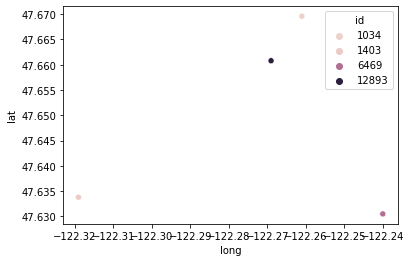

In [17]:
# 부자 가구 상위 4개 추출
# 위에서 만든 per_price(평당 가격), zipcdoe_mean(zipcode 그룹별 평균 가격) 기준
temp_data_train = data_train.loc[(data_train['per_price15'] > 0.8)&(data_train['per_price'] > 0.59)&(data_train['zipcode_mean'] > 15.3)]
#df_temp = df_train.loc[(df_train['price'] > 15.5)]
sns.scatterplot(x='long', y='lat', hue='id', hue_order=np.sort(temp_data_train['price'].unique()), data=temp_data_train)
temp_data_train

In [20]:
lat_rich = []
for lat_ in temp_data_train['lat'].values:
    lat_rich.append(lat_)
long_rich = []
for lat_ in temp_data_train['long'].values:
    long_rich.append(lat_)
lat_rich

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2,per_price,per_price15,zipcode_mean,zipcode_var
2095,2095,20140606,12.660331,3,1.5,7.467942,9.433564,1.0,0,0,...,4,2,20,4,0.234137,0.205808,0.553323,0.749135,12.149911,0.038849
5077,5077,20150122,12.043560,2,1.0,7.123673,9.200391,1.0,0,0,...,8,15,48,16,-0.037613,-0.129441,0.553614,0.747889,12.097493,0.008023
10301,10301,20140711,11.982935,3,1.5,7.300473,8.853808,1.0,0,0,...,3,2,19,3,0.059251,-0.308945,0.546208,0.741948,12.156162,0.004538


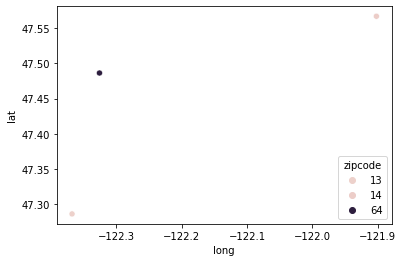

In [21]:
# 가난한 가구 하위 3개 추출
# 위에서 만든 per_price(평당 가격), zipcdoe_mean(zipcode 그룹별 평균 가격) 기준
temp_data_train = data_train.loc[(data_train['per_price15'] < 0.75)&(data_train['per_price'] < 0.56)&(data_train['zipcode_mean'] < 12.2)]
#df_temp = df_train.loc[(df_train['price'] > 15.5)]
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(temp_data_train['price'].unique()), data=temp_data_train)
temp_data_train

In [22]:
lat_pool = []
for lat_ in temp_data_train['lat'].values:
    lat_pool.append(lat_)
long_pool = []
for lat_ in temp_data_train['long'].values:
    long_pool.append(lat_)
lat_pool

[47.5666, 47.4862, 47.2866]

In [23]:
# 각 가구별 부자/가난 가구와의 거리 feature로 추가
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

for df in [data_train, data_test]:
    idx = 0
    for lat_, long_ in zip(lat_rich, long_rich):
        idx += 1
        df['rich_lat_long' + str(idx)] = haversine_array(lat_, long_, df['lat'], df['long'])
    for lat_, long_ in zip(lat_pool, long_pool):
        idx += 1
        df['poor_lat_long' + str(idx)] = haversine_array(lat_, long_, df['lat'], df['long'])
    
#     df['rich_lat_long1'] = haversine_array(rich_lat1, rich_long1,df['lat'],df['long'])
#     df['rich_lat_long2'] = haversine_array(rich_lat2, rich_long2,df['lat'],df['long'])
#     df['rich_lat_long3'] = haversine_array(rich_lat3, rich_long3,df['lat'],df['long'])
#     df['rich_lat_long4'] = haversine_array(rich_lat4, rich_long4,df['lat'],df['long'])
#     df['poor_lat_long1'] = haversine_array(poor_lat1, poor_long1,df['lat'],df['long'])
#     df['poor_lat_long2'] = haversine_array(poor_lat2, poor_long2,df['lat'],df['long'])
#     df['poor_lat_long3'] = haversine_array(poor_lat3, poor_long3,df['lat'],df['long'])


In [25]:
 data_train['rich_lat_long3']

0        13.326720
1        11.953826
2        14.693474
3        36.265777
4        25.211204
           ...    
15030    14.094951
15031    14.605266
15032    11.024341
15033    16.162383
15034     5.995221
Name: rich_lat_long3, Length: 15035, dtype: float64

In [ ]:
y_reg = np.expm1(data_train['price'])

In [31]:
train_columns = [c for c in data_train.columns if c not in ['id','price','per_price', 'per_price15']]

In [33]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(data_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(data_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = data_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[08:13:58] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:13:58] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:13:58] WARNING: ../src/objective/regression_obj.cu:171:

In [34]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(data_train[train_columns], y_reg)
dtest = xgb.DMatrix(data_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = data_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[08:19:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:40] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:19:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:40] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:19:40] WARNING: ../src/objective/regression_obj.cu:171:

In [35]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [36]:
xgb_sub

,id,price
0,15035,5.152720e+05
1,15036,4.772316e+05
2,15037,1.301080e+06
3,15038,2.921062e+05
4,15039,3.343112e+05
...,...,...
6463,21498,2.478117e+05
6464,21499,4.027543e+05
6465,21500,4.811322e+05
6466,21501,3.190701e+05


In [37]:
xgb_sub.to_csv("submission.csv",index=False)